# Project "Vehicle Detection"

Interessante Udacitiy-Lektionen:
Project 15


In [8]:
from sklearn import svm, grid_search
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import cv2
import glob
import imp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle
import time
import vehicle_detection
%matplotlib inline


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
imp.reload(vehicle_detection)


<module 'vehicle_detection' from '/Users/harald/Documents/Daten/dev/Udacity/CarND/CarND-Vehicle-Detection/vehicle_detection.py'>

In [6]:
# Read in the training data from a pickle or create the pickle if it does not exist yet.
FORCE_READ_TRAINING_DATA = True
PICKLE_NAME = "./vehicle_detection.p"

DEBUG=False

if os.path.exists(PICKLE_NAME) and not FORCE_READ_TRAINING_DATA:  
    # Load training iamges
    trainData = pickle.load(open(PICKLE_NAME, "rb"))
    featureList = trainData['featureList']
    labels = trainData['labels']
    ORIENTATION = trainData["ORIENTATION"]
    PIX_PER_CELL = trainData["PIX_PER_CELL"]
    CELL_PER_BLOCK = trainData["CELL_PER_BLOCK"]
    print("Training data loaded.")

else:
    # Declare the parameter for extract_features()
    ORIENTATION = 9
    PIX_PER_CELL = 8
    CELL_PER_BLOCK = 2

    print("Reading trainig data ...")
    t0 = time.time()
    featureList = []
    labels = []

    # Read in all "car" images
    for fn in glob.glob("training_data/cars/*/*"):
        img = cv2.imread(fn)
        feat, imgHog = vehicle_detection.extract_features(img, 
                                                          ORIENTATION, 
                                                          PIX_PER_CELL, 
                                                          CELL_PER_BLOCK,
                                                          toVector = True,
                                                          visualize = False)
        featureList.append(feat)
        labels.append(1)

    # Read all "notcar" images
    for fn in glob.glob("training_data/notcars/*/*"):
        img = cv2.imread(fn)
        feat, imgHog = vehicle_detection.extract_features(img,
                                                          ORIENTATION,
                                                          PIX_PER_CELL,
                                                          CELL_PER_BLOCK,
                                                          toVector = True,
                                                          visualize = False)
        featureList.append(feat)
        labels.append(0)
        
    print("Reading trainig data took {:5.3f} seconds".format(time.time() - t0))

    # Save training data
    dist_pickle = {}
    dist_pickle["featureList"] = featureList
    dist_pickle["labels"] = labels
    dist_pickle["ORIENTATION"] = ORIENTATION
    dist_pickle["PIX_PER_CELL"] = PIX_PER_CELL
    dist_pickle["CELL_PER_BLOCK"] = CELL_PER_BLOCK
    pickle.dump(dist_pickle, open(PICKLE_NAME, "wb"))
    print("Training data saved.")


Reading trainig data ...


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Reading trainig data took 40.628 seconds
Training data saved.


In [7]:
if DEBUG:
    f, sub = plt.subplots(3, 2, figsize=(20,10))
    X = np.vstack(features).astype(np.float64)
    print("fn:", fn)
    print("type(feat):", type(feat), "  feat.shape:", feat.shape)
    print("X.shape:", len(X), " labels.shape:", len(labels))
    print("X[0].shape:", X[0].shape)
    print("X:", X)
    sub[n, 0].imshow(img)
    sub[n, 0].set_title("Original image")
    sub[n, 1].imshow(imgHog, cmap="gray")
    sub[n, 1].set_title("imgHog")
    n+=1
    if n == 3:
        print("X:", X)

X_data = np.vstack(featureList).astype(np.float64)
X_scaler = StandardScaler().fit(X_data)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_data)

print("len(X_data):", len(X_data), " len(labels):", len(labels), "  mean(labels):", np.mean(np.array(labels)))
        
X_train, X_test, y_train, y_test = train_test_split(scaled_X, np.array(labels), test_size=0.2)    
    
print("X_train.shape:", X_train.shape, "  y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "  y_test.shape:", y_test.shape)



len(featureList): 20081
X_data.shape: (20081, 1764)
len(X_data): 20081  len(labels): 20081   mean(labels): 0.497385588367
X_train.shape: (16064, 1764)   y_train.shape: (16064,)
X_test.shape: (4017, 1764)   y_test.shape: (4017,)


In [9]:
print("Training the SVM classifier ...")
t0 = time.time()

parameters = {"kernel": ("linear", "rbf"), "C": (1, 10)}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test) 
acc = accuracy_score(y_test, y_pred)
print("Training the SVM classifier took {:5.3f}".format(time.time() - t0))
print("accuracy:", acc)
print(clf)


Training the SVM classifier ...
Training the SVM classifier took 750.559
accuracy: 0.992033856112
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': (1, 10)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [10]:
print("clf.best_params_:", clf.best_params_)

clf.best_params_: {'kernel': 'rbf', 'C': 10}


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


labels found: 2


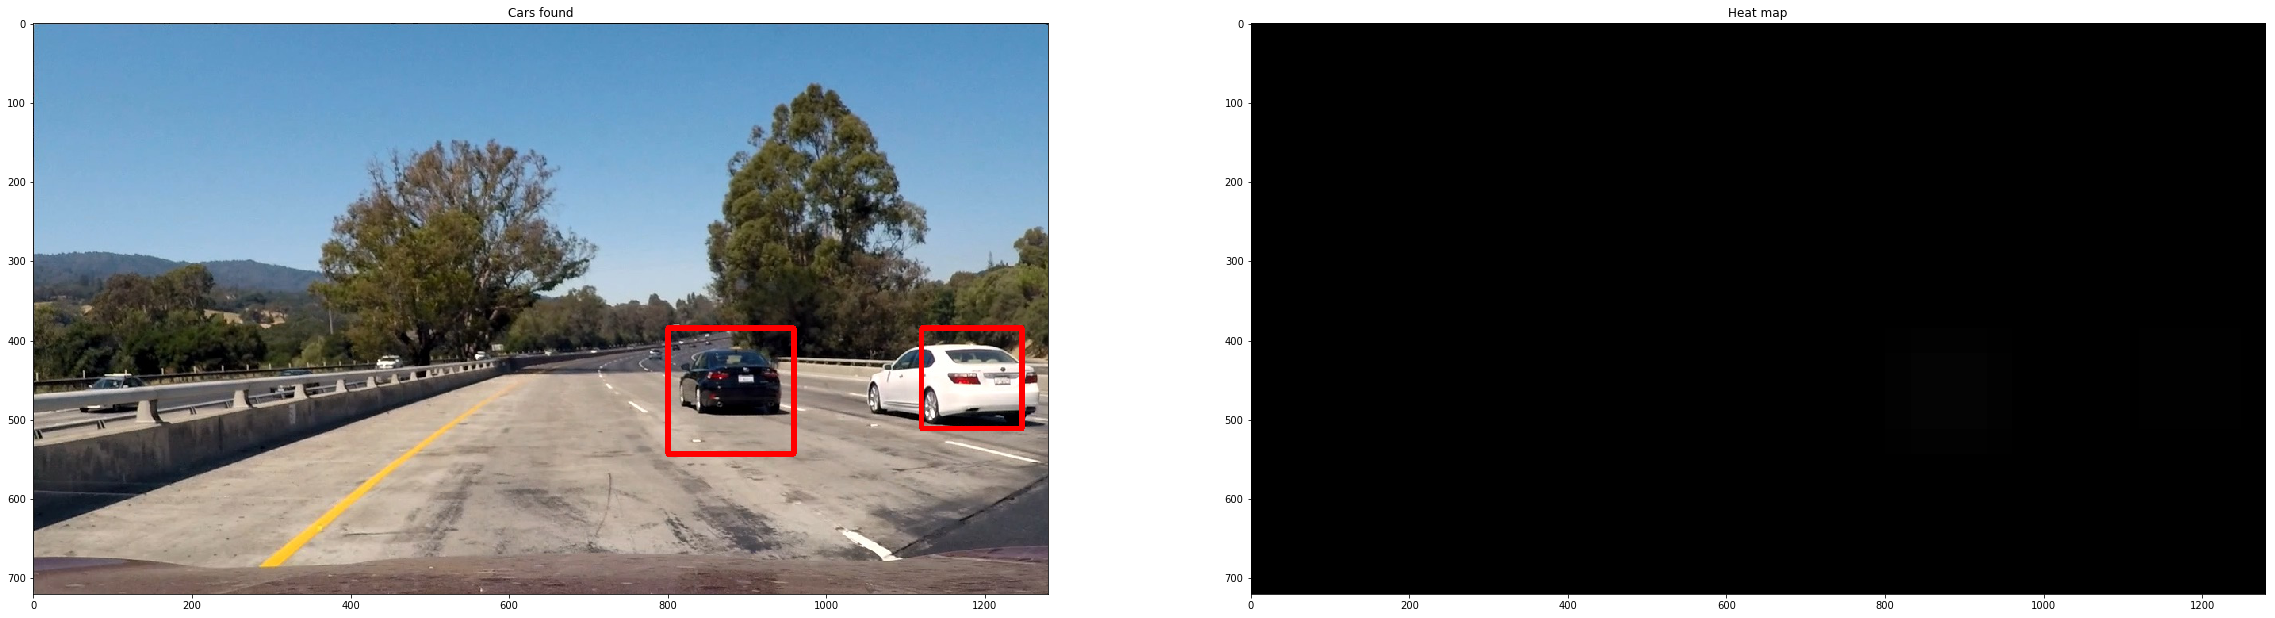

In [28]:
IMAGE_FILE = "test_images/test1.jpg"
#SCALE = 1.5
SCALE_Y_TOP = 352
SCALE_Y_BOTTOM = 672
winPosStep = 16

def findCars(img, winStep, fromY=0, toY=-1):
    if toY < 0:
        toY = img.shape[0]
#    imgPlt2 = np.copy(img)
#    heatMap = np.zeros_like(img)[:,:,0]

    for SCALE in [1.5, 2.0]:
        imgScaled = cv2.resize(img[fromY:toY,:,:], 
                               (int(img.shape[1]/SCALE), 
                                int((toY-fromY)/SCALE)))

        hog, hogImg = vehicle_detection.extract_features(imgScaled, 
                                                           ORIENTATION, 
                                                           PIX_PER_CELL, 
                                                           CELL_PER_BLOCK, 
                                                           toVector=False,
                                                           visualize=True)
        blocks_per_win = PIX_PER_CELL - CELL_PER_BLOCK +1
        cells_per_step = 2
        nxsteps = (imgScaled.shape[1] // PIX_PER_CELL) - CELL_PER_BLOCK +1
        nysteps = (imgScaled.shape[0] // PIX_PER_CELL) - CELL_PER_BLOCK +1

        if False:
            print("hogImg.shape:", hogImg.shape)
            print("hog.shape:", hog.shape)
            print("blocks_per_win:", blocks_per_win)
            print("steps:", nxsteps, "/", nysteps)
        nxsteps = (nxsteps - blocks_per_win) // cells_per_step
        nysteps = (nysteps - blocks_per_win) // cells_per_step
    #    print("steps:", nxsteps, "/", nysteps)

        featureList2 = []
        winPosList2 = []

        for xc in range(nxsteps):
            xCell = xc * cells_per_step
            xLeft = xCell * PIX_PER_CELL

            for yc in range(nysteps):
                yCell = yc * cells_per_step
                yTop  = yCell * PIX_PER_CELL
                winPosList2.append((xLeft, yTop))
                hogFeat = hog[yCell:yCell+blocks_per_win, xCell:xCell+blocks_per_win].ravel()
                featureList2.append(hogFeat)
    #            print("cell:", xCell, "/", yCell, " -> pos:", xLeft, "/", yTop)
                if False:
                    cv2.rectangle(imgPlt2, 
                                  (int(xLeft*SCALE), int(yTop*SCALE+fromY)), 
                                  (int(xLeft*SCALE+64), int(yTop*SCALE+fromY+64)), 
                                  (0, 255, 255),
                                  4)

        X_scan2 = np.vstack(featureList2).astype(np.float64)
        X_scan_scaled2 = X_scaler.transform(X_scan2)    
        #print("X_scan_scaled.shape:", X_scan_scaled.shape, "  X_scan_scaled:", X_scan_scaled)
        y_scan2 = clf.predict(X_scan_scaled2)
        idxFound2 = np.nonzero(y_scan2)[0]
        realWinSize = int(64 * SCALE)
        foundPosList2 = [(np.array(winPosList2[i])*SCALE+np.array((0, SCALE_Y_TOP)), 
                          (realWinSize, realWinSize)) for i in idxFound2]
#        print("Car2 found at ", foundPosList2)
    return foundPosList2

def drawHeatMap(heatMap, foundCars):
    for (foundX, foundY), (winDimX, winDimY) in foundCars:
        left = int(foundX)
        top = int(foundY)
        right = min(left+winDimX, heatMap.shape[1])
        bottom = min(top+winDimY, heatMap.shape[0])
        heatMap[top:bottom, left:right] += 1
    return heatMap

def applyThreshold(heatMap, threshold):
    heatMap[heatMap <= threshold] = 0
    return heatMap
    

###################################################
# Load the image
img = cv2.imread(IMAGE_FILE)
foundCars = findCars(img, winPosStep, SCALE_Y_TOP, SCALE_Y_BOTTOM)

heatMap = np.zeros_like(img)
heatMap = drawHeatMap(heatMap, foundCars)
heatMap = applyThreshold(heatMap, 0)

labels = label(heatMap)
print("labels found:", labels[1])
imgPlt = np.copy(img)
for carNum in range(1, labels[1]+1):
    nonzero = (labels[0] == carNum).nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    cv2.rectangle(imgPlt, bbox[0], bbox[1], (0,0,255), 6)

f, sub = plt.subplots(1, 2, figsize=(40,20))
#plt.figure(figsize=(100, 50))
sub[0].imshow(vehicle_detection.cv2mpimg(imgPlt))
sub[0].set_title("Cars found")
sub[1].imshow(heatMap, cmap="hot", vmin=0, vmax=1)
sub[1].set_title("Heat map")


In [30]:
# Select the video: "project", "challenge" or "harder_challenge"
videoName = "project"

videoReader = cv2.VideoCapture("{:s}_video.mp4".format(videoName))
videoWriter = cv2.VideoWriter("./output_images/{:s}_video.mp4".format(videoName), cv2.VideoWriter_fourcc(*'mp4v') , 25.0, (1280,720))
if not videoWriter.isOpened():
    print("ERROR: Could not open VideoWriter")
    exit()

frameNo = 0
while videoReader.isOpened():
    ret, img = videoReader.read()
    if not ret:
        break;
    frameNo += 1
#    print("Processing frame", frameNo)

    foundCars = findCars(img, winPosStep, SCALE_Y_TOP, SCALE_Y_BOTTOM)

    heatMap = np.zeros_like(img)
    heatMap = drawHeatMap(heatMap, foundCars)
    heatMap = applyThreshold(heatMap, 1)

    labels = label(heatMap)
    imgOut = np.copy(img)
    for carNum in range(1, labels[1]+1):
        nonzero = (labels[0] == carNum).nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imgOut, bbox[0], bbox[1], (0,0,255), 6)

    cv2.putText(imgOut, "Frame: {:d}".format(frameNo), (150,50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))

    videoWriter.write(imgOut)

videoWriter.release()
videoReader.release()
print("Done")


Processing frame 1


/Users/harald/miniconda3/envs/CarND/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Done
